In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [2]:
from struct import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ucitavanje_slika(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_slika = unpack(">I", fp.read(4))[0]
        broj_redova = unpack(">I", fp.read(4))[0]
        broj_kolona = unpack(">I", fp.read(4))[0]
        
        slike = np.frombuffer(fp.read(broj_slika*broj_redova*broj_kolona), dtype=np.uint8).reshape((broj_slika, broj_redova, broj_kolona))
        slike = slike.astype(np.float32)
        return slike

def ucitavanje_labela(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_labela = unpack(">I", fp.read(4))[0]
        labele = np.frombuffer(fp.read(broj_labela), dtype=np.uint8)
        return labele

# train_slike = ucitavanje_slika("train-images.idx3-ubyte")
# train_labele = ucitavanje_labela("train-labels.idx1-ubyte")

# test_slike = ucitavanje_slika("t10k-images.idx3-ubyte")
# test_labele = ucitavanje_labela("t10k-labels.idx1-ubyte")

In [3]:
class MnistDataset(Dataset):
    def __init__(self, putanja_do_slika, putanja_do_labela):
        super().__init__()
        
        slike = ucitavanje_slika(putanja_do_slika)
        labele = ucitavanje_labela(putanja_do_labela)
        
        self.podaci = list(zip(slike.reshape(len(slike), slike[0].shape[0]*slike[0].shape[1]) , labele))
        # self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]) , labele))
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]
    
    def __len__(self):
        return len(self.podaci)

In [4]:
train_dataset = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_dataset = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [5]:
train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [7]:
class Mreza(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Linear(28*28, 400)
        self.enc2 = nn.Linear(400, 200)
        self.enc3 = nn.Linear(200, 100)
        self.enkodovana_vrednost = nn.Linear(100, 10)
        self.dec1 = nn.Linear(10, 100)
        self.dec2 = nn.Linear(100, 400)
        self.dec3 = nn.Linear(400, 28*28)
    
    def encode(self, x):
        return F.tanh(self.enkodovana_vrednost(self.enc3(self.enc2(self.enc1(x)))))
    
    def decode(self, x):
        return F.relu(self.dec3(self.dec2(self.dec1(x))))
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [30]:
mreza = Mreza()

funkcija_greske = nn.MSELoss()
optimizer = torch.optim.RMSprop(mreza.parameters(), lr=0.001)

broj_epoha = 2

for i in range(broj_epoha):
    for (x, y) in train_podaci:
        yp = mreza(x)
        optimizer.zero_grad()
        greska = funkcija_greske(yp, x)
        greska.backward()
        optimizer.step()
    print(i)

0
1


In [31]:
slika = next(iter(test_podaci))
cifra = slika[0][0]

enkodovano = mreza.encode(cifra)
dekodovano = mreza.decode(enkodovano)

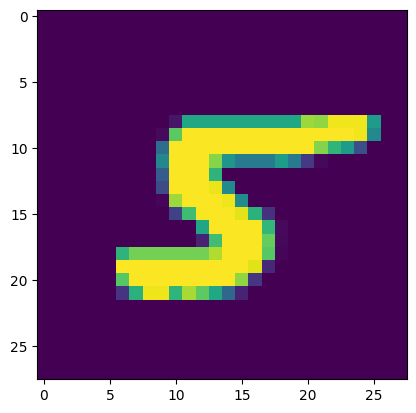

In [32]:
plt.figure()
plt.imshow(cifra.reshape(28, 28))
plt.show()

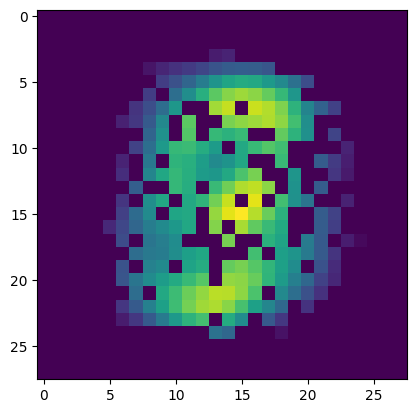

In [33]:
plt.figure()
plt.imshow(dekodovano.detach().numpy().reshape(28, 28))
plt.show()

In [34]:
enkodovano

tensor([-1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.],
       grad_fn=<TanhBackward0>)

In [43]:
dekodovano = mreza.decode(torch.rand(10))

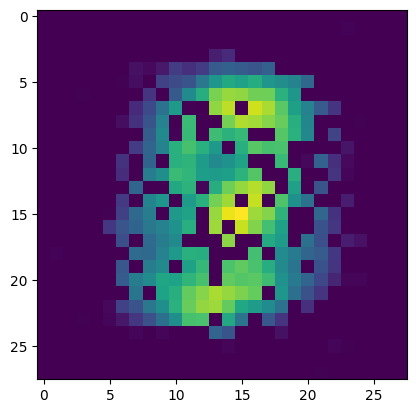

In [44]:
plt.figure()
plt.imshow(dekodovano.detach().numpy().reshape(28, 28))
plt.show()

In [47]:
class MnistDataset(Dataset):
    def __init__(self, putanja_do_slika, putanja_do_labela):
        super().__init__()
        
        slike = ucitavanje_slika(putanja_do_slika)
        labele = ucitavanje_labela(putanja_do_labela)
        
        self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]) , labele))
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]
    
    def __len__(self):
        return len(self.podaci)

train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [99]:
class CNNMreza(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(1, 5, 3, 2)
        self.enc2 = nn.Conv2d(5, 10, 3)
        self.enc3 = nn.Conv2d(10, 5, 3)
        self.enc4 = nn.Conv2d(5, 1, 3)
        
        self.dec1 = nn.ConvTranspose2d(1, 3, 3)
        self.dec2 = nn.ConvTranspose2d(3, 10, 3)
        self.dec3 = nn.ConvTranspose2d(10, 5, 3)
        self.dec4 = nn.ConvTranspose2d(5, 1, 3, 2, output_padding=1)
        
        # self.linearni1 = nn.Linear(10*28*28, 500)
        # self.linearni2 = nn.Linear(500, 10)
    def encode(self, x):
        return F.tanh(self.enc4(self.enc3(self.enc2(self.enc1(x)))))
    
    def decode(self, x):
        return self.dec4(self.dec3(self.dec2(self.dec1(x))))
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [100]:
train_dataset = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_dataset = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [101]:
train_podaci = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_podaci = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [102]:
mreza = CNNMreza()

funkcija_greske = nn.MSELoss()
optimizer = torch.optim.RMSprop(mreza.parameters(), lr=0.001)

broj_epoha = 2

for i in range(broj_epoha):
    for (x, y) in train_podaci:
        yp = mreza(x)
        optimizer.zero_grad()
        greska = funkcija_greske(yp, x)
        greska.backward()
        optimizer.step()
    print(i)

0
1


tensor([[[-1., -1., -1., -1., -1.,  1., -1.],
         [-1., -1., -1., -1.,  1., -1.,  1.],
         [-1., -1., -1.,  1.,  1., -1.,  1.],
         [-1., -1.,  1.,  1., -1.,  1., -1.],
         [-1.,  1., -1.,  1., -1., -1., -1.],
         [ 1., -1., -1.,  1., -1., -1., -1.],
         [ 1., -1.,  1., -1.,  1., -1., -1.]]], grad_fn=<TanhBackward0>)


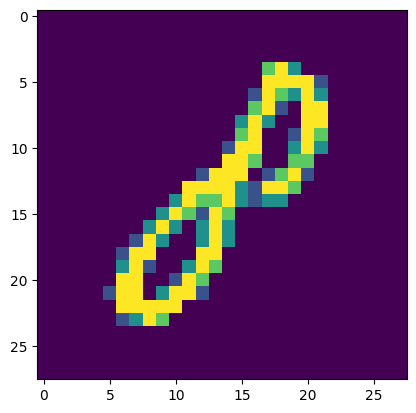

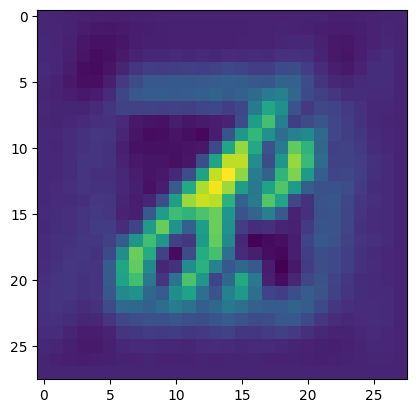

torch.Size([1, 7, 7])
torch.Size([1, 28, 28])


In [104]:
slika = next(iter(test_podaci))
cifra = slika[0][0]

rezultat = mreza.encode(cifra)
print(rezultat)
dekodovano = mreza.decode(rezultat)

plt.figure()
plt.imshow(cifra[0])
plt.show()

plt.figure()
plt.imshow(dekodovano.detach().numpy()[0])
plt.show()

print(rezultat.shape)
print(dekodovano.shape)